<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/Copy_of_customer_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import datetime
from calendar import monthrange
from tqdm import tqdm
from sklearn import preprocessing
import warnings


pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv('/cup98LRN.txt')
raw_df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,...,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,,,,XXXX,T2,36,60.0,,,,,,,NaN,NaN,...,240.0,31,14,5.0,9208,12.0,9402,10.0,9512,8911,9003.0,4.0,7.741935,95515,0,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,,,5202,0,,,,,XXXX,S1,14,46.0,E,H,,,,M,1.0,6.0,...,47.0,3,1,10.0,9310,25.0,9512,25.0,9512,9310,9504.0,18.0,15.666667,148535,0,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,,,0,0,,,,,XXXX,R2,43,NaN,,U,,,,,NaN,3.0,...,202.0,27,14,2.0,9111,16.0,9207,5.0,9512,9001,9101.0,12.0,7.481481,15078,0,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,,,2801,0,,,,,XXXX,R2,44,70.0,E,U,,,,,NaN,1.0,...,109.0,16,7,2.0,8711,11.0,9411,10.0,9512,8702,8711.0,9.0,6.812500,172556,0,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,,0,FL,33176,,,2001,0,X,X,,,XXXX,S2,16,78.0,E,H,,,,,1.0,3.0,...,254.0,37,8,3.0,9310,15.0,9601,15.0,9601,7903,8005.0,14.0,6.864865,7112,0,0.0,1,L,2,F,X,X,X,26.0,A


### Data Cleaning

In [0]:
# obtain the median action date of each kind of action, which will be used to fill nan

# date_cols = [col for col in raw_df.columns if 'ADATE_' in col]

# mid_date = raw_df.loc[:,date_cols].median().astype(int)
# mid_date


In [0]:
# data type conversion

# mid_date = pd.to_datetime(mid_date, format='%y%m', errors='coerce')

# for col in date_cols:
#     raw_df[col] = pd.to_datetime(raw_df[col], format='%y%m', errors='coerce')



In [0]:
# mid_date.values

In [3]:
# obtain action mapping
# seperate donation information from basic information

action_mapping = {
    2: '97NK',
    3: '96NK',
    4: '96TK',
    5: '96SK',
    6: '96LL',
    7: '96G1',
    8: '96GK', 
    9: '96CC',
    10: '96WL',
    11: '96X1',
    12: '96XK',
    13: '95FS',
    14: '95NK',
    15: '95TK',
    16: '95LL',
    17: '95G1',
    18: '95GK',
    19: '95CC',
    20: '95WL',
    21: '95X1',
    22: '95XK',
    23: '94FS',
    24: '94NK'
}

list_df = []
for i in tqdm(range(2,25)):
    act_date = 'ADATE_{}'.format(i)
    RFM = 'RFA_{}'.format(i)
    
    if (i == 2):
        rew_date = 'RDATE_3'
        rew_amt = 'TARGET_D'
    else:
        rew_date = 'RDATE_{}'.format(i)
        rew_amt = 'RAMNT_{}'.format(i)
    
    tmp = raw_df[['CONTROLN', act_date, rew_date, rew_amt, RFM]]
    tmp = tmp.rename(columns={act_date: 'action_date', rew_date: 'reward_date', rew_amt: 'reward', RFM: 'rfm'})
    tmp['action'] = action_mapping[i]
    tmp['key'] = i
    list_df.append(tmp)
    
prepared_df = pd.concat(list_df)
prepared_df = prepared_df.sort_values(['CONTROLN','key'])

prepared_df.head(20)

100%|██████████| 23/23 [00:00<00:00, 124.97it/s]


,CONTROLN,action_date,reward_date,reward,rfm,action,key
52895,1,9706.0,NaN,0.0,L3F,97NK,2
52895,1,9606.0,NaN,NaN,S3F,96NK,3
52895,1,9604.0,NaN,NaN,S3F,96TK,4
52895,1,9604.0,NaN,NaN,S3F,96SK,5
52895,1,9603.0,NaN,NaN,S4F,96LL,6
52895,1,9602.0,NaN,NaN,S4F,96G1,7
52895,1,9601.0,NaN,NaN,S4F,96GK,8
52895,1,9511.0,NaN,NaN,S3F,96CC,9
52895,1,NaN,NaN,NaN,,96WL,10
52895,1,9510.0,NaN,NaN,S2F,96X1,11


In [0]:
prepared_df=prepared_df.reset_index().drop(columns=["index"])

In [0]:
# preprocess action rewards
def reward(row):
    if pd.isnull(row["action_date"]):
        return 0
    if pd.isnull(row["reward_date"]):
        return -0.68
    else:
        return (row["reward"]-0.68)

In [0]:
# preprocess actions
def action(row):
    if pd.isnull(row["action_date"]):
        return "NA"
    else:
        return row["action"]

In [0]:
def decision(row):
    if pd.isnull(row["action_date"]):
        return 0
    else:
        return 1

In [0]:
# # preprocess action dates
# def date(row):
#     if pd.isnull(row["action_date"]):
#         return row["median"]
#     else:
#         return row["action_date"]

In [0]:
prepared_df["reward"]=prepared_df.apply(reward, axis=1)

In [0]:
prepared_df["action"]=prepared_df.apply(action, axis=1)

In [0]:
prepared_df["rfm"]=prepared_df["rfm"].apply(lambda x: np.NaN if x==' ' else x)

In [0]:
prepared_df["rfm"]=prepared_df[["CONTROLN","rfm"]].groupby("CONTROLN").fillna(method='bfill')['rfm']

In [0]:
prepared_df["rfm"]=prepared_df[["CONTROLN","rfm"]].groupby("CONTROLN").fillna(method='ffill')['rfm']

In [0]:
prepared_df["decision"]=prepared_df.apply(decision, axis=1)

In [0]:
# mid_date.values

In [0]:
# new=prepared_df["key"].apply(lambda x: mid_date.values[x-2] if True else x)

In [0]:
# prepared_df=prepared_df.assign(median=new)

In [0]:
# prepared_df["action_date"]=prepared_df.apply(date, axis=1)

In [0]:
# prepared_df=prepared_df.drop(columns=['median'])

In [14]:
prepared_df.head(100)

,CONTROLN,action_date,reward_date,reward,rfm,action,key,decision
0,1,9706.0,NaN,-0.68,L3F,97NK,2,1
1,1,9606.0,NaN,-0.68,S3F,96NK,3,1
2,1,9604.0,NaN,-0.68,S3F,96TK,4,1
3,1,9604.0,NaN,-0.68,S3F,96SK,5,1
4,1,9603.0,NaN,-0.68,S4F,96LL,6,1
...,...,...,...,...,...,...,...,...
95,7,NaN,NaN,0.00,A1E,NA,5,0
96,7,9603.0,NaN,-0.68,A1E,96LL,6,1
97,7,9602.0,NaN,-0.68,L2D,96G1,7,1
98,7,9601.0,NaN,-0.68,L2D,96GK,8,1


In [0]:
# obtain basic information
state_cols = [
    'CONTROLN',
    'AGE',
    'HOMEOWNR',
    'NUMCHLD',
    'INCOME',
    'GENDER',
    'WEALTH1',
    'MAJOR',
    'WEALTH2',
    'BIBLE',   
    'CATLG',   
    'HOMEE',   
    'PETS',    
    'CDPLAY',  
    'STEREO',  
    'PCOWNERS',
    'PHOTO',   
    'CRAFTS',  
    'FISHER',  
    'GARDENIN',
    'BOATS',   
    'WALKER',  
    'KIDSTUFF',
    'CARDS',   
    'PLATES',
    'CLUSTER',
    'CLUSTER2',
    'RAMNTALL',
    'NGIFTALL',
    'CARDGIFT',
    'AVGGIFT',
    'NUMPROM'
    
]

states = raw_df[state_cols]

In [0]:
del raw_df

In [0]:
#normalization
min_max_scaler = preprocessing.MinMaxScaler()

for c in state_cols:
    if (c != 'CONTROLN') & (states[c].dtype != np.dtype('O')):
        states[[c]] = min_max_scaler.fit_transform(states[[c]])

In [0]:
#normalization
nan_columns = states.columns[states.isna().any()]

imputedValues = {}
for c in nan_columns:
    if states[c].dtype == np.dtype('O'):
        imputedValues[c] = 'NA' 
    else: 
        imputedValues[c] = 0 
states = states.fillna(imputedValues)

In [18]:
l=[]
for c in states.columns:
    if states[c].dtype=='O':
        l.append(c)
states[l]

,HOMEOWNR,GENDER,MAJOR,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,CLUSTER
0,,F,,,,,,,,,,,,,,,,,,36
1,H,M,,,,,,,,,,,,,,,,,,14
2,U,M,,,,,,,,,,,,,,,,,,43
3,U,F,,,,,,,,,,,,,,,,,,44
4,H,F,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,,M,,,,,,,,,,,,,,,,,,27
95408,H,M,,,,,,,,,,,,,,,,,,24
95409,,M,,,,,,,,,,,,,,,,,,30
95410,H,F,,,,,,,,,,,,,,,,,,24


In [0]:
for i in ["HOMEOWNR","GENDER", "CLUSTER"]:
    l.remove(i)
states=states.drop(columns=l)

In [0]:
states=pd.get_dummies(states)

In [0]:
pre_reward = prepared_df[["CONTROLN","reward"]].groupby("CONTROLN").sum()       # estimated cumulative rewards

In [22]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

modeloRF = RandomForestRegressor(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=50, 
                                 n_jobs=-1, 
                                 random_state=42)
modeloRF.fit(states.drop(columns=['CONTROLN']),pre_reward)

feature_importance_df = pd.DataFrame(states.drop(columns=['CONTROLN']).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

result = feature_importance_df.sort_values('importance',ascending=False)
print(result)



       Feature  importance
9      AVGGIFT    0.145282
6     RAMNTALL    0.129472
10     NUMPROM    0.120177
5     CLUSTER2    0.113226
0          AGE    0.105073
..         ...         ...
27  CLUSTER_06    0.000214
18    GENDER_J    0.000135
73  CLUSTER_52    0.000037
16    GENDER_C    0.000000
15    GENDER_A    0.000000

[75 rows x 2 columns]


In [0]:
features=result[result.iloc[:,1]>0.05]['Feature'].values

In [0]:
features=np.append(features,"CONTROLN")

In [0]:
states = states[features]

In [40]:
# Prepare for nueral network: merge basic information, rfm and actions
merged=pd.merge(prepared_df[["CONTROLN","action","rfm","reward",'key', 'decision']],states, how='left', on="CONTROLN")
merged

,CONTROLN,action,rfm,reward,key,decision,AVGGIFT,RAMNTALL,NUMPROM,CLUSTER2,AGE,NGIFTALL,CARDGIFT
0,1,97NK,L3F,-0.68,2,1,0.021492,0.027449,0.293194,0.016393,0.835052,0.04661,0.146341
1,1,96NK,S3F,-0.68,3,1,0.021492,0.027449,0.293194,0.016393,0.835052,0.04661,0.146341
2,1,96TK,S3F,-0.68,4,1,0.021492,0.027449,0.293194,0.016393,0.835052,0.04661,0.146341
3,1,96SK,S3F,-0.68,5,1,0.021492,0.027449,0.293194,0.016393,0.835052,0.04661,0.146341
4,1,96LL,S4F,-0.68,6,1,0.021492,0.027449,0.293194,0.016393,0.835052,0.04661,0.146341
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194471,191779,NA,P1G,0.00,20,0,0.023745,0.001267,0.073298,0.163934,0.721649,0.00000,0.024390
2194472,191779,NA,P1G,0.00,21,0,0.023745,0.001267,0.073298,0.163934,0.721649,0.00000,0.024390
2194473,191779,NA,P1G,0.00,22,0,0.023745,0.001267,0.073298,0.163934,0.721649,0.00000,0.024390
2194474,191779,NA,P1G,0.00,23,0,0.023745,0.001267,0.073298,0.163934,0.721649,0.00000,0.024390


In [0]:
merged = pd.get_dummies(merged, columns=['rfm'])

In [42]:
modeloRF = RandomForestRegressor(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=30, 
                                 n_jobs=-1, 
                                 random_state=42)

modeloRF.fit(merged.drop(columns=['CONTROLN','action','reward','key','decision']),merged['reward'])

feature_importance_df = pd.DataFrame(merged.drop(columns=['CONTROLN','action','reward','key','decision']).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

result = feature_importance_df.sort_values('importance',ascending=False)
print(result)



      Feature  importance
1    RAMNTALL    0.209518
0     AVGGIFT    0.177620
2     NUMPROM    0.124884
3    CLUSTER2    0.082783
4         AGE    0.072225
..        ...         ...
9      rfm_1E    0.000000
16     rfm_3F    0.000000
98    rfm_N2A    0.000000
105   rfm_N3B    0.000000
15     rfm_3E    0.000000

[149 rows x 2 columns]


In [0]:
features=result[result.iloc[:,1]>0.05]['Feature'].values

In [0]:
features=np.append(features,['CONTROLN','action','reward','key', 'decision'])

In [0]:
merged = merged[features]

In [0]:
merged["reward"] = merged[["reward"]].groupby(merged["CONTROLN"]).cumsum()

In [47]:
merged

,RAMNTALL,AVGGIFT,NUMPROM,CLUSTER2,AGE,NGIFTALL,CARDGIFT,CONTROLN,action,reward,key,decision
0,0.027449,0.021492,0.293194,0.016393,0.835052,0.04661,0.146341,1,97NK,-0.68,2,1
1,0.027449,0.021492,0.293194,0.016393,0.835052,0.04661,0.146341,1,96NK,-1.36,3,1
2,0.027449,0.021492,0.293194,0.016393,0.835052,0.04661,0.146341,1,96TK,-2.04,4,1
3,0.027449,0.021492,0.293194,0.016393,0.835052,0.04661,0.146341,1,96SK,-2.72,5,1
4,0.027449,0.021492,0.293194,0.016393,0.835052,0.04661,0.146341,1,96LL,-3.40,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2194471,0.001267,0.023745,0.073298,0.163934,0.721649,0.00000,0.024390,191779,NA,17.52,20,0
2194472,0.001267,0.023745,0.073298,0.163934,0.721649,0.00000,0.024390,191779,NA,17.52,21,0
2194473,0.001267,0.023745,0.073298,0.163934,0.721649,0.00000,0.024390,191779,NA,17.52,22,0
2194474,0.001267,0.023745,0.073298,0.163934,0.721649,0.00000,0.024390,191779,NA,17.52,23,0


In [0]:
merged = pd.get_dummies(merged)

In [0]:
X = merged.drop(columns=['CONTROLN','reward','key']).values
y = merged["reward"].values
X = np.array_split(X, 95412)
y = np.array_split(y, 95412)
X = np.asarray(X)
y = np.asarray(y)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
del merged
import gc
gc.collect()

288

In [54]:
!pip uninstall tensorflow
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 37kB/s 
     |████████████████████████████████| 3.8MB 36.7MB/s 
     |████████████████████████████████| 512kB 44.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=af870e36cef195afc1ec3ff3022b0f966c9c97e5a6a9f83a608e3747213e0e20
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0


In [0]:
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping


In [0]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [0]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K
def get_lstm(x_tr,y_tr,x_val,y_val):
    K.clear_session()

    model = Sequential()
    model.add(LSTM(23,go_backwards = True))
    model.add(Dense(23))
    
    model.compile(optimizer = 'Adam',
                  loss='mse', 
                  metrics=['mse'])
    
    es = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=50)

    mc = callbacks.ModelCheckpoint('best_model.h5',
                         monitor='val_loss',
                         mode='min',
                         save_best_only=True, 
                         verbose=1, 
                         save_weights_only=True)
    
    model.fit(x_tr, y_tr,
              validation_data=[x_val, y_val],
              callbacks = [es,mc],
              epochs=100, 
              batch_size=128,
              verbose=1,
              shuffle=True)
    
    model.load_weights("best_model.h5")

    return model

In [92]:
model = get_lstm(X_train,y_train,X_test,y_test)

Train on 76329 samples, validate on 19083 samples
Epoch 1/1
76329/76329 [==============================] - 18s 238us/step - loss: 432.2086 - mse: 432.2086 - val_loss: 353.1668 - val_mse: 353.1668

Epoch 00001: val_loss improved from inf to 353.16676, saving model to best_model.h5


In [0]:
model.save('my_model.hdf5')

In [0]:
from keras.models import load_model

def base(states,v):

  X_train, X_test, y_train, y_test = train_test_split(states, v, test_size=0.2, random_state=42)

  K.clear_session()

  model = load_model('my_model.hdf5')
  
  es = EarlyStopping(monitor='val_loss', 
                      mode='min',
                      restore_best_weights=True, 
                      verbose=1, 
                      patience=50)

  mc = callbacks.ModelCheckpoint('best_model.h5',
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True, 
                        verbose=1, 
                        save_weights_only=True)
  
  model.fit(X_train, y_train,
            validation_data=[X_test, y_test],
            callbacks = [es,mc],
            epochs=1, 
            batch_size=128,
            verbose=1,
            shuffle=True)
  
  model.load_weights("best_model.h5")

  return model

In [0]:
rewards = prepared_df['reward'].values

In [0]:
model = load_model('my_model.hdf5')

In [0]:
def direct_rl(model, states, rewards):        # here rewards are estimated cumulative rewards
  Q = []
  v = model.predict(states)        #return the estimated cumulative rewards for each states and actions
  Q.append(v)
  cnt = 0
  for k in range(7):
    cnt = 0
    for i in range(95412):
      for j in range(23):
        if j != 22:
          v[i][j] = v[i][j] + alpha*(rewards[cnt]+gamma*v[i][j+1]-v[i][j])
        cnt += 1
    model = base(states, v)
    v = model.predict(states)
    Q.append(v)
  return Q

In [0]:
alpha = 0.1       # learning rate
gamma = 0.9       # discount rate

In [118]:
Q=direct_rl(model, X, rewards)

Train on 76329 samples, validate on 19083 samples
Epoch 1/1
76329/76329 [==============================] - 18s 232us/step - loss: 0.3357 - mse: 0.3357 - val_loss: 0.3143 - val_mse: 0.3143

Epoch 00001: val_loss improved from inf to 0.31428, saving model to best_model.h5
Train on 76329 samples, validate on 19083 samples
Epoch 1/1
76329/76329 [==============================] - 18s 235us/step - loss: 0.3442 - mse: 0.3442 - val_loss: 0.3144 - val_mse: 0.3144

Epoch 00001: val_loss improved from inf to 0.31436, saving model to best_model.h5
Train on 76329 samples, validate on 19083 samples
Epoch 1/1
76329/76329 [==============================] - 17s 227us/step - loss: 0.3583 - mse: 0.3583 - val_loss: 0.3146 - val_mse: 0.3146

Epoch 00001: val_loss improved from inf to 0.31459, saving model to best_model.h5
Train on 76329 samples, validate on 19083 samples
Epoch 1/1
76329/76329 [==============================] - 17s 229us/step - loss: 0.3764 - mse: 0.3764 - val_loss: 0.3148 - val_mse: 0.3148

In [124]:
prepared_df

,CONTROLN,action_date,reward_date,reward,rfm,action,key,decision
0,1,9706.0,NaN,-0.68,L3F,97NK,2,1
1,1,9606.0,NaN,-0.68,S3F,96NK,3,1
2,1,9604.0,NaN,-0.68,S3F,96TK,4,1
3,1,9604.0,NaN,-0.68,S3F,96SK,5,1
4,1,9603.0,NaN,-0.68,S4F,96LL,6,1
...,...,...,...,...,...,...,...,...
2194471,191779,NaN,NaN,0.00,P1G,NA,20,0
2194472,191779,NaN,NaN,0.00,P1G,NA,21,0
2194473,191779,NaN,NaN,0.00,P1G,NA,22,0
2194474,191779,NaN,NaN,0.00,P1G,NA,23,0


In [121]:
s = []
for i in range(8):
  s.append(Q[i][:,22].sum())
s

[1512225.1,
 1516900.5,
 1520064.1,
 1522207.0,
 1523659.8,
 1524646.9,
 1525318.8,
 1525778.1]

In [125]:
s_true = prepared_df['reward'].sum()
s_true

2681141.2100000004

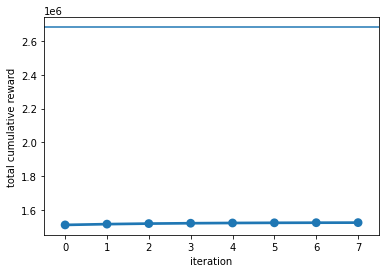

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.pointplot(x = list(range(8)), y = s)
g.axhline(s_true)
plt.xlabel('iteration')
plt.ylabel('total cumulative reward')
plt.show()